# Dog Image Classification by Breed
This project applies Neural Networks to a dataset of dog images. In this project, each dog image is classified by its breed by training several models in efforts to determine the model with the highest accuracy score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2 
import keras
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K
from keras.applications import xception
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Softmax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
import requests
from PIL import Image, ImageFile
from io import BytesIO
import re
from sklearn.metrics import confusion_matrix

# Importing Data
The data consists of 20,580 images and 120 different classes of dog breeds. Using keras functions, the data is imported from its path and the train-test split is performed. Setting validation_split to 0.2 allows a 80-20 train-test split. 

In [2]:
batch_size = 32
img_height = 256
img_width = 256
data_dir='/Users/anishamalhotra/Desktop/Images'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


# Exploratory Data Analysis
Viewing image shape and label shape, then plotting a sample image.

In [33]:
images = np.zeros((32,256,256,3))
labels = np.zeros((32,))
for image, label in train_ds:
    images = image
    labels = label
    print(image.shape)
    print(label.shape)
    break

(32, 256, 256, 3)
(32,)


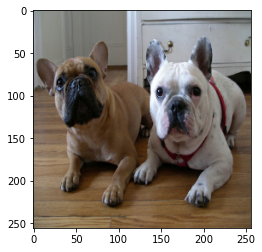

In [34]:
plt.imshow(images[0]/255.)

Printing all labels to view all classes.

In [35]:
class_names = train_ds.class_names
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

Plotting 9 random images from data to view.

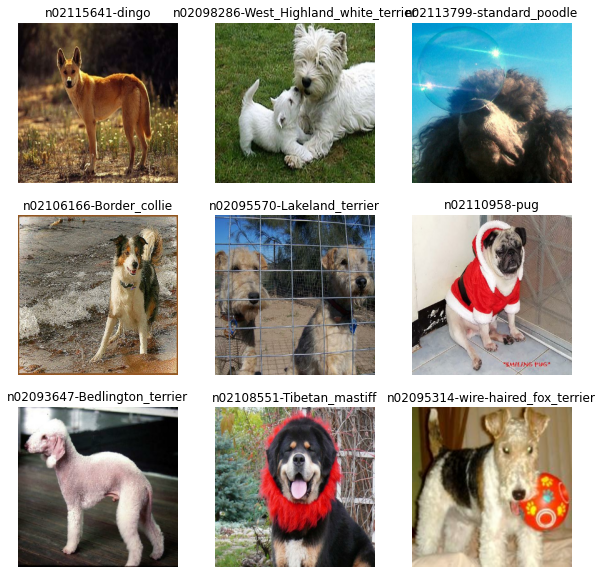

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Plotting number of images per class to check for class imbalance issues and get an overall view of the data.

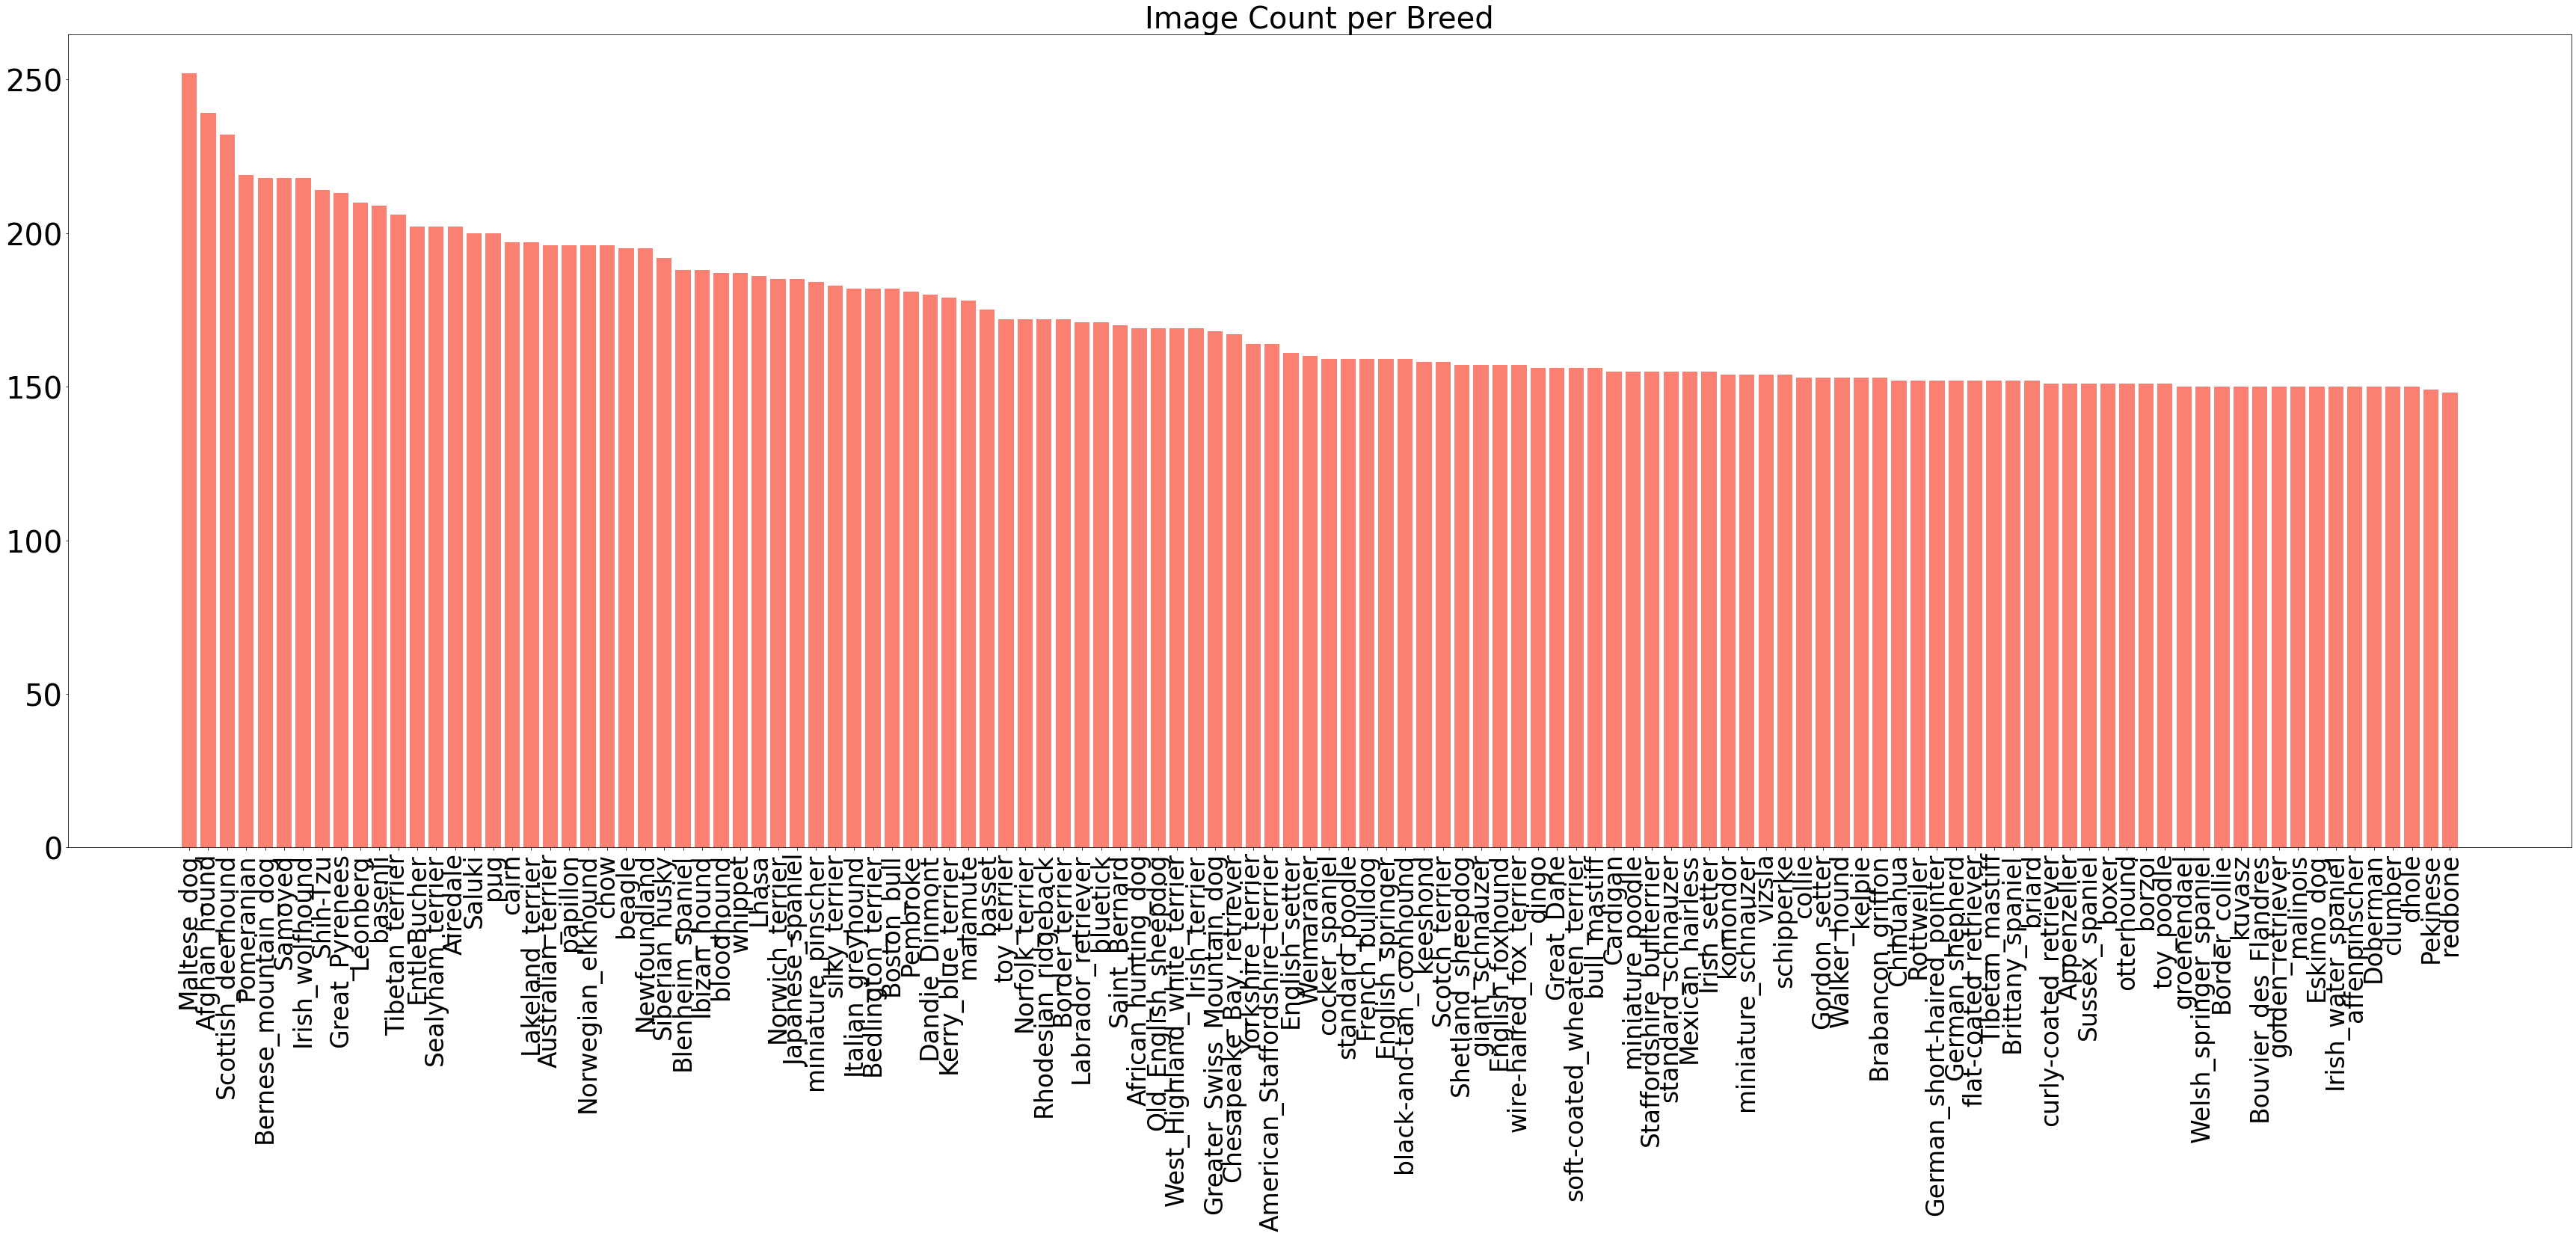

In [37]:
df = pd.DataFrame(sorted(glob.glob('/Users/anishamalhotra/Desktop/Images/*/*')), columns = ['path'])
df['labels'] = df['path'].apply(lambda x: x.split('/')[-2].split('-',1)[1])

breeds = df['labels'].value_counts()
ax, fig = plt.subplots(figsize = (60,20))
plt.bar(breeds.index, breeds.values, color = 'salmon')
plt.xticks(breeds.index, rotation=90, fontsize=33)
plt.title('Image Count per Breed', fontsize = 40)
plt.yticks(fontsize = 40)

plt.show()


There is no significant class imbalance issue, however it is evident that the breed with the most images are Maltese.

### Commonly confused breeds
There are many breeds that look similar and that may be confused by the model. Here are some commonly mixed up breeds plotted and later I will see how the model performs on them.

<img src="https://i.pinimg.com/originals/2e/dc/4c/2edc4c1a3b2cc3a1b419a34ae6994e24.jpg" alt= "huksymalamute" >

<img src="https://littlepawstraining.com/wp-content/uploads/2019/09/American-eskimo-vs-Samoyed-size-comparison.png" alt= "eskimosamoyed" >



# Scaling
Converting data to a 0 to 1 scale in order to prepare data for modeling and setting other parameters to allow model to get different views and zooms of the image.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, 
                                   zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(data_dir, target_size=(256, 256),
                                                    batch_size=32)
test_generator = test_datagen.flow_from_directory(data_dir, target_size=(256, 256),
                                                        batch_size=32)

Found 20580 images belonging to 120 classes.
Found 20580 images belonging to 120 classes.


In [40]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32, 120)


# Modeling

### Model 1
Baseline model with 11 layers, activation - 'relu', regularization by 0.25 dropout layers

In [14]:
model_1 = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(120, activation='relu')])

In [15]:
model_1.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [16]:
history_1 = model_1.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator)

Epoch 1/10
644/644 [==============================] - 1004s 2s/step - loss: 14.2715 - accuracy: 0.0118 - val_loss: 14.2554 - val_accuracy: 0.0154
Epoch 2/10
644/644 [==============================] - 960s 1s/step - loss: 14.2603 - accuracy: 0.0153 - val_loss: 14.2591 - val_accuracy: 0.0152
Epoch 3/10
644/644 [==============================] - 978s 2s/step - loss: 14.2429 - accuracy: 0.0154 - val_loss: 14.1627 - val_accuracy: 0.0194
Epoch 4/10
644/644 [==============================] - 962s 1s/step - loss: 14.1532 - accuracy: 0.0184 - val_loss: 14.1575 - val_accuracy: 0.0171
Epoch 5/10
644/644 [==============================] - 960s 1s/step - loss: 14.1569 - accuracy: 0.0187 - val_loss: 14.1521 - val_accuracy: 0.0118
Epoch 6/10
644/644 [==============================] - 962s 1s/step - loss: 14.1542 - accuracy: 0.0185 - val_loss: 14.1430 - val_accuracy: 0.0210
Epoch 7/10
644/644 [==============================] - 967s 2s/step - loss: 14.1535 - accuracy: 0.0216 - val_loss: 14.1526 - val_a

With a validation accuracy of 2.30%, this model does not perform well. By adding more layers to this model, maybe the accuracy will increase.

### Model 2
Adding to original model: 13 layers, activation - 'relu', last layer classification - 'softmax', adding regularization by 0.2 dropout layers

In [17]:
model_2 = models.Sequential()

model_2.add(layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same', 
                          input_shape=(256,256,3), data_format = 'channels_last'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(Dropout(0.2))

model_2.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dropout(0.2))
model_2.add(Dense(120, activation = 'softmax'))

In [18]:
model_2.compile(loss='categorical_crossentropy', 
                optimizer = 'adam', 
                metrics = ['accuracy'])


In [19]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)       

In [20]:
history_2 = model_2.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator)

Epoch 1/10
644/644 [==============================] - 1001s 2s/step - loss: 4.6999 - accuracy: 0.0185 - val_loss: 4.5342 - val_accuracy: 0.0365
Epoch 2/10
644/644 [==============================] - 999s 2s/step - loss: 4.4898 - accuracy: 0.0417 - val_loss: 4.2857 - val_accuracy: 0.0727
Epoch 3/10
644/644 [==============================] - 1005s 2s/step - loss: 4.2602 - accuracy: 0.0713 - val_loss: 4.0877 - val_accuracy: 0.1100
Epoch 4/10
644/644 [==============================] - 1007s 2s/step - loss: 4.0203 - accuracy: 0.1035 - val_loss: 3.7823 - val_accuracy: 0.1542
Epoch 5/10
644/644 [==============================] - 1062s 2s/step - loss: 3.8449 - accuracy: 0.1327 - val_loss: 3.6908 - val_accuracy: 0.1741
Epoch 6/10
644/644 [==============================] - 1014s 2s/step - loss: 3.6902 - accuracy: 0.1555 - val_loss: 3.4147 - val_accuracy: 0.2177
Epoch 7/10
644/644 [==============================] - 1003s 2s/step - loss: 3.5837 - accuracy: 0.1746 - val_loss: 3.4858 - val_accuracy: 

With a validation accuracy of 332.22%, this model did much better, but still not great. Going to now try some transfer learning models to see if this will help increase the accuracy score.

## Transfer Learning
Using pre-trained models to see if there are better results.
### Inception Model
InceptionV3 Model with .4 and .2 Dropout layers and Batch Normalization

In [7]:
inputs = keras.Input(shape=(256, 256, 3))

base_model = keras.applications.InceptionV3(
    weights = 'imagenet',
    input_shape=(256, 256, 3),
    include_top=False)

base_model.trainable = False

x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)

model = keras.Model(base_model.input, outputs)

for layer in base_model.layers:
    layer.trainable = False


In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [9]:
history = model.fit(
        train_generator,
        epochs=20,
        validation_data=test_generator)

Epoch 1/20
644/644 [==============================] - 4203s 7s/step - loss: 1.6105 - accuracy: 0.6665 - val_loss: 1.0889 - val_accuracy: 0.7770
Epoch 2/20
644/644 [==============================] - 4138s 6s/step - loss: 1.0703 - accuracy: 0.7570 - val_loss: 0.7113 - val_accuracy: 0.8167
Epoch 3/20
644/644 [==============================] - 4112s 6s/step - loss: 0.8651 - accuracy: 0.7829 - val_loss: 0.6033 - val_accuracy: 0.8425
Epoch 4/20
644/644 [==============================] - 4084s 6s/step - loss: 0.7494 - accuracy: 0.8032 - val_loss: 0.5095 - val_accuracy: 0.8571
Epoch 5/20
644/644 [==============================] - 4086s 6s/step - loss: 0.6818 - accuracy: 0.8155 - val_loss: 0.4607 - val_accuracy: 0.8713
Epoch 6/20
644/644 [==============================] - 4076s 6s/step - loss: 0.5925 - accuracy: 0.8348 - val_loss: 0.4751 - val_accuracy: 0.8694
Epoch 7/20
644/644 [==============================] - 4073s 6s/step - loss: 0.5530 - accuracy: 0.8391 - val_loss: 0.3466 - val_accuracy:

This model is performing really well with an accuracy in the high 90s. Going to try one more transfer learning model to see if it does even better.

In [10]:
model.save('inception') #saving best model


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: inception/assets


In [11]:
# final_model = tf.keras.models.load_model('inception')


### ResNet Model
ResNet50 Model with .4 and .2 Dropout layers and Batch Normalization

In [24]:
resnet = ResNet50(
    input_shape= (256,256,3),
    include_top=False,
    weights='imagenet')

resnet.trainable = False

y = resnet.output
y = keras.layers.Flatten()(y)
y = keras.layers.Dropout(0.4)(y)
y = keras.layers.Dense(2048, activation='relu')(y)
y = keras.layers.BatchNormalization()(y)
y = keras.layers.Dropout(0.4)(y)
y = keras.layers.Dense(2048, activation='relu')(y)
y = keras.layers.BatchNormalization()(y)
y = keras.layers.Dropout(0.2)(y)
outputs = keras.layers.Dense(120, activation='softmax')(y)

model_resnet = keras.Model(resnet.input, outputs)

for layer in resnet.layers:
    layer.trainable = False

In [25]:
model_resnet.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [26]:
history_resnet = model_resnet.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator)

Epoch 1/10
644/644 [==============================] - 6313s 10s/step - loss: 5.8097 - accuracy: 0.0182 - val_loss: 5.5939 - val_accuracy: 0.0267
Epoch 2/10
644/644 [==============================] - 7730s 12s/step - loss: 5.4177 - accuracy: 0.0240 - val_loss: 5.1740 - val_accuracy: 0.0298
Epoch 3/10
644/644 [==============================] - 6662s 10s/step - loss: 5.2360 - accuracy: 0.0274 - val_loss: 5.0360 - val_accuracy: 0.0403
Epoch 4/10
644/644 [==============================] - 7028s 11s/step - loss: 5.0544 - accuracy: 0.0287 - val_loss: 4.8478 - val_accuracy: 0.0440
Epoch 5/10
644/644 [==============================] - 6816s 11s/step - loss: 4.9091 - accuracy: 0.0356 - val_loss: 4.7801 - val_accuracy: 0.0456
Epoch 6/10
644/644 [==============================] - 6721s 10s/step - loss: 4.7981 - accuracy: 0.0363 - val_loss: 4.6057 - val_accuracy: 0.0552
Epoch 7/10
644/644 [==============================] - 6738s 10s/step - loss: 4.6807 - accuracy: 0.0407 - val_loss: 4.3412 - val_ac

This model seemed to do worse than expected. The inception model seemed to be the most accurate model.

# Evaluation

In [29]:
eval_df = pd.DataFrame({
    'model_1': history_1.history['val_accuracy'][-1],
    'model_2': history_2.history['val_accuracy'][-1],
    'inception_model': history.history['val_accuracy'][-1],
    'resnet_model': history_resnet.history['val_accuracy'][-1]
})

eval_df

,model_1,model_2,inception_model,resnet_model
Accuracy Score,2.30%,32.22%,96.12%,8.29%


Based on the accuracy score of all of the models, the Inception model is the most accurate model with a score of 91.97%. The confusion matrix and accuracy and loss per epoch will be plotted for this model.

**Confusion Matrix**

In [27]:
Y_pred = model.predict(test_generator, batch_size=32)

In [33]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

Confusion Matrix
[[1 2 2 ... 0 1 1]
 [2 0 1 ... 2 2 2]
 [4 1 4 ... 1 1 4]
 ...
 [0 2 3 ... 2 3 1]
 [2 1 1 ... 1 0 1]
 [1 3 1 ... 1 2 0]]


**Accuracy and Loss Plots**

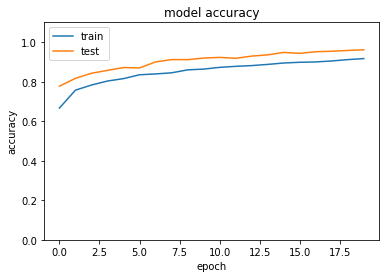

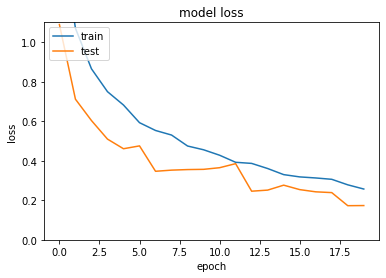

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1.1])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1.1])
plt.show()

# Predicitons

In [17]:
def predict_breed(loc):
    key_list = list(train_generator.class_indices.keys())
    response = requests.get(loc)
    img = Image.open(BytesIO(response.content))
    
    img = img.resize((256, 256))
    img = np.array(img) / 255
    
    pred = np.argmax(model.predict(img.reshape(1, 256, 256, 3)), axis=1)
    plt.title("Predicted: " + re.search(r'\-(.*)', key_list[int(pred)]).group(0))
    plt.axis('off')
    plt.imshow(img)

**Commonly Confused Breeds**
Coming back to commonly confused breeds discussed earlier, this is how the model performs on them.

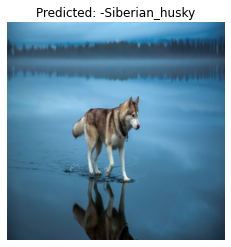

In [19]:
predict_breed('https://i.imgur.com/uKnMvyp.jpeg')

The model corrected predicted this image of a Siberian Husky.

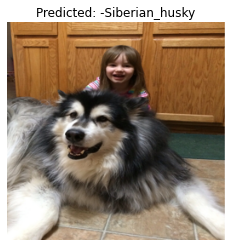

In [20]:
predict_breed('https://i.imgur.com/g7nWj6L.jpeg')

This is an image of a Malamute that has been classified as a Siberian Husky.

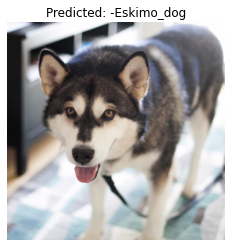

In [21]:
predict_breed('https://i.imgur.com/5UeUc6H.jpg')

This is an image of a Malamute that has been classified as an Eskimo dog.

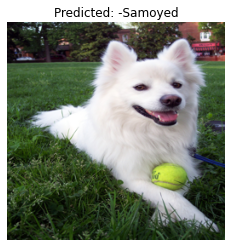

In [22]:
predict_breed('https://i.imgur.com/pSrsKXY.jpeg')

This is an image of an Eskimo Dog that has been classified as a Samoyed.

**Correct Prediction**

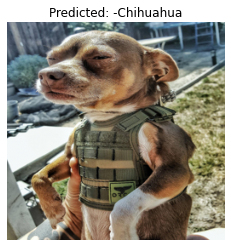

In [74]:
predict_breed('https://i.imgur.com/H37kxPH.jpeg')

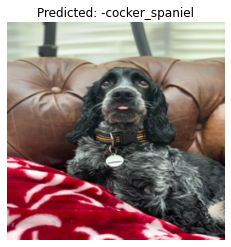

In [65]:
predict_breed('https://i.imgur.com/O6CTWbz.jpg')
    

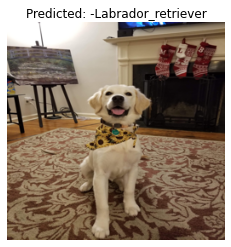

In [76]:
predict_breed('https://i.imgur.com/asxJN9Z.jpg')


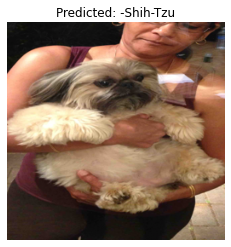

In [71]:
predict_breed('https://i.imgur.com/eXr1Ghh.png')

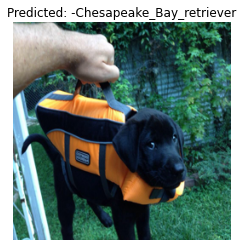

In [28]:
predict_breed('https://i.imgur.com/Y7rCXCF.jpeg')

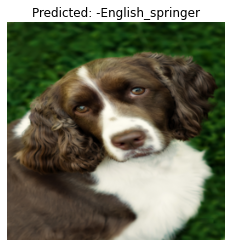

In [93]:
predict_breed('https://i.imgur.com/X05Y76O.jpeg')


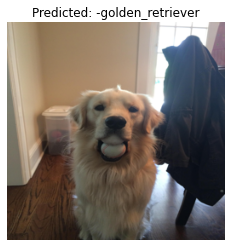

In [122]:
predict_breed('https://i.imgur.com/XgbZdeA.jpeg')


# Conclusion
As seen in the Predictions section, there are some similar looking breeds that the model mistakes for other breeds. Because the model is at 96% accuracy there are some wrong predictions, however the model does correctly predict dog breeds for the most part.
# Next Steps
- Include images of mixed breeds for the model to differentiate (ex: cockapoo, puggle)
- Create a recommendation system that recommends similar breeds based on input image
- Create app/front end for users to input images